Para este ejercicio se han propuesto cinco modelos entrenados, utilizando dos algoritmos distintos: Logistic Regression y XGBoost. Los cinco modelos tienen una performance bastante pobre, principalmente debido a la poca capacidad de predecir un vuelo atrasado (True Positive, de ahora en mas TP). En general los modelos analizados son
buenos prediciendo casos de vuelos puntuales (True Negative), poseen una tasa muy baja de falsos postivos (FP), pero por otro lado poseen una alta tasa de falsos negativos (FN).

De los cinco modelos propuestos el que pareciera tener mejor performance es el XGBoost con upsampling, ya que al normalizar la matriz de confusión encontramos que el porcentaje de TP es 19%, manteniendo los TN en 93%. Sin embargo creo que el análisis de resultados no es válido ya que el upsampling fue realizado antes de realizar el train-test split. El upsampling debe realizarse luego del splitting y sobre los datos de train, ya que de lo contrario hay altas chances de que el modelo esté expuesto a "data leakage", i.e., observaciones de entrenamiento que estarán repetidos en el test set.

Por lo tanto, elegiremos el modelo XGBoost con optimización de hiperparámetros mediante GridSearch: éste modelo obtuvo una tasa de TN del 99& y una tasa de TN del 4%.


Como mejora, se propone:

    1. Utilizar un modelo XGBoost con el mejor set de hiperparámetros obtenidos: {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.5}
    
    2. Corregir el upsampling para que sólo se realice sobre los datos de entrenamiento.
    
    3. Modificar el threshold de predicción: Por defecto en los clasificadores binarios se considera que cuando 
    el score de predicción de la clase "positiva" es mayor a 0.5, entonces la predicción de la obervación es 
    de dicha clase. Sin embargo modificar este valor nos puede ayudar a disminuir los FN, aunque a expensas de aumentar los FP.
        
    4. Explorar qué sucede si agregamos como predictor adicional una variable de tipo numérica, por ejemplo la hora de vuelo.

con los parámetros {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.5} (obtenidos de la optimización de hiperparámetros mediante el método GridSearch)

In [4]:
import pandas as pd
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

import os
import json
from datetime import datetime
import joblib

In [5]:

# Load features from cv
df = pd.read_csv('features.csv')

# Add an extra numerical feature: hour
df["Fecha-I"] = pd.to_datetime(df["Fecha-I"])
df["hour"] = df["Fecha-I"].dt.hour

data = shuffle(df, random_state = 111) 
data.head()

/tmp/ipykernel_19534/3779635517.py:2: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('features.csv')


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,temporada_alta,dif_min,atraso_15,periodo_dia,hour
13375,2017-03-24 07:30:00,142,SCEL,SCFA,SKU,2017-03-24 07:29:00,142,SCEL,SCFA,SKU,...,Viernes,N,Sky Airline,Santiago,Antofagasta,0,-1.0,0,mañana,7
35799,2017-07-27 21:06:00,221,SCEL,SCIE,LAN,2017-07-27 21:09:00,221,SCEL,SCIE,LXP,...,Jueves,N,Grupo LATAM,Santiago,Concepcion,1,3.0,0,noche,21
48176,2017-09-13 01:50:00,380,SCEL,SCAR,LAN,2017-09-13 01:54:00,380,SCEL,SCAR,LXP,...,Miercoles,N,Grupo LATAM,Santiago,Arica,1,4.0,0,noche,1
58675,2017-11-03 06:35:00,160,SCEL,SCDA,LAN,2017-11-03 06:35:00,160,SCEL,SCDA,LAN,...,Viernes,N,Grupo LATAM,Santiago,Iquique,0,0.0,0,mañana,6
23374,2017-05-29 10:40:00,43,SCEL,SCVD,SKU,2017-05-29 10:35:00,43,SCEL,SCVD,SKU,...,Lunes,N,Sky Airline,Santiago,Valdivia,0,-5.0,0,mañana,10


#### Useful functions

In [6]:

CATEGORICAL_COLS = ['OPERA', 'TIPOVUELO', 'MES'] # categorical features
#NUMERIC_COLS = ["hour"] # numerical feature

MODEL_FEATURES = CATEGORICAL_COLS# + NUMERIC_COLS
BEST_PARAMS = {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.5} # best hiperparameters obtained before
TARGET_LABEL = "atraso_15" # target label

def upsample(data):
    """
    Upsamples the class '1' data.
    """

    data_no_retraso = data[data[TARGET_LABEL] == 0]
    data_atraso = data[data[TARGET_LABEL] == 1]

    data_atraso_upsampled = resample(data_atraso, 
                                     replace = True,     # sample with replacement
                                     n_samples = 30000,    # to match majority class
                                     random_state = 42) # reproducible results
    

    data_upsampled = pd.concat([data_no_retraso, data_atraso_upsampled])
    return data_upsampled

def postproc_preds(class_preds, th=0.7):
    """
    prediction postprocessing: if class prediction score is greater than threshold, we will say that the
    observation belongs to the '1' class, otherwise the observation will be asigned to the '0' class.
    """
    y_predict_class = [1 if score > th else 0 for score in class_preds]
    return y_predict_class

def get_pipeline(numeric_cols = None):
    """
    Builds a pipeline that consists in:
     * preprocessing steps: standard scaler for numerical features (if included) and one hot encoding for 
       categorical features.
     * classifier step: predictions of the preprocessed data.
     
     Returns a Pipeline object.
     
    """
    
    transformers=[
            ("scaler", StandardScaler(), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_COLS),
        ] if numeric_cols else [("cat", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_COLS)]

    preprocessor = ColumnTransformer(
        transformers=transformers
    )


    pipe = Pipeline(
        steps=[
            ("prepro", preprocessor),
            ("classifier", xgb.XGBClassifier(random_state=1, max_depth = 10, 
                                             **BEST_PARAMS))
        ]
    )
    return pipe

def export_pipeline(pipeline, name, version, classes, postproc_type, postproc_params):
    """
    Export the pipeline model package. The package consists in:
     * compressed pipeline in .pkl format
     * Pipeline metadata: contains name, version and output processing params. Thi information will be used
       for configuring the prediction service.
    """

    metadata = {
       "name": name,
       "version": version,
       "classes": classes, 
       "post_proc": {
          "type": postproc_type,
          "params": postproc_params     
       },
       "date": datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    }
    
    os.makedirs(name, exist_ok=True)
    
    joblib.dump(pipeline, f"{name}/{name}.pkl", compress = 1)
    
    with open(f"{name}/{name}_metadata.json", 'w') as jfile:
        json.dump(metadata, jfile, indent=4)
    
    


### 1) and 2) Train a XGBoost upsampling the train set.

In [7]:
data = shuffle(df, random_state = 111)


features = data[MODEL_FEATURES]
label = data[TARGET_LABEL]


x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.33, random_state = 42)

upsample_train = upsample(pd.concat([x_train, y_train], axis=1))
x_train, y_train = upsample_train[MODEL_FEATURES], upsample_train[TARGET_LABEL]

pipe=get_pipeline()

pipe.fit(x_train, y_train)
print("model score: %.3f" % pipe.score(x_test, y_test))

model score: 0.691


In [8]:
y_pred = pipe.predict(x_test)
confusion_matrix(y_test, y_pred, normalize="true")

array([[0.73547791, 0.26452209],
       [0.51108404, 0.48891596]])

We have an increase in the TP rate, but on the other hand the FP rate has increased too.

### 3) Let's see what happen if we tune the threshold:

In [9]:

tn_rates = []
tp_rates = []

ths = np.linspace(0,1,40)

for th in ths:
    y_pred = pipe.predict_proba(x_test) # get the scores for both classes
    y_pred = postproc_preds(y_pred[:, 1], th=th)

    cm = confusion_matrix(y_test, y_pred, normalize="true")
    tn_rates.append(cm[0][0])
    tp_rates.append(cm[1][1])

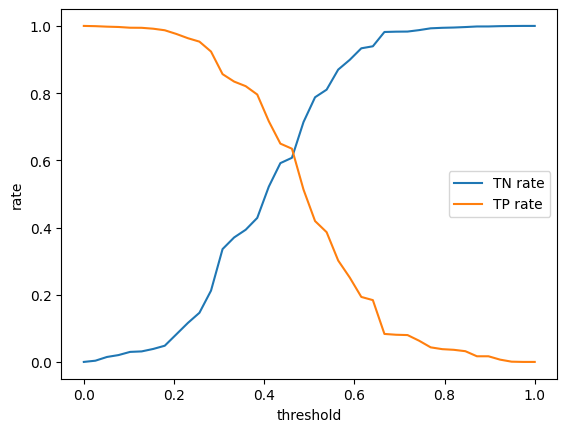

In [10]:
plt.plot(ths, tn_rates, label="TN rate")
plt.plot(ths, tp_rates, label="TP rate")
plt.xlabel("threshold")
plt.ylabel("rate")
plt.legend()

In the graphic above, we notice that we can make a balance between TP and TN by moving the threshold. 
I will chose a threshold 0.59, so the TN = 90% and TP 25%. This decision was based on the idea that we want to keep FP positive low (it may not be a good idea if we say to people that an airplane will be delayed, while in fact is arriving on time...), but with an increase in the TP rate. The TP rate is still quite low, although we have improved from 4% to 25% our power for predicting delayed flights.

In [11]:
y_pred = pipe.predict_proba(x_test)
y_pred = postproc_preds(y_pred[:, 1], th=0.59)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87     18403
           1       0.36      0.25      0.29      4105

    accuracy                           0.78     22508
   macro avg       0.60      0.58      0.58     22508
weighted avg       0.75      0.78      0.77     22508



In [12]:
confusion_matrix(y_test, y_pred, normalize="true") * 100

array([[89.90382003, 10.09617997],
       [74.88428745, 25.11571255]])

_______________________________

### 4) Let's see what happen if we include a numerical feature: hour.

In [13]:
NUMERIC_COLS = ["hour"] # numerical feature

MODEL_FEATURES = CATEGORICAL_COLS + NUMERIC_COLS # we redefine the model features

In [14]:
features = data[MODEL_FEATURES]
label = data[TARGET_LABEL]


x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.33, random_state = 42)

upsample_train = upsample(pd.concat([x_train, y_train], axis=1))
x_train, y_train = upsample_train[MODEL_FEATURES], upsample_train[TARGET_LABEL]

pipe=get_pipeline(numeric_cols=NUMERIC_COLS)

pipe.fit(x_train, y_train)
print("model score: %.3f" % pipe.score(x_test, y_test))

model score: 0.698


In [15]:
TH = 0.61
y_pred = pipe.predict_proba(x_test)
y_pred = postproc_preds(y_pred[:, 1], th=TH)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88     18403
           1       0.40      0.29      0.33      4105

    accuracy                           0.79     22508
   macro avg       0.62      0.60      0.60     22508
weighted avg       0.77      0.79      0.78     22508



We see here that, using threshold = 0.61, we keep our TN rate (90%) but whe improve TP rate to 29%, i.e., this new feature allows us to gain 4% of accuracy for predicting delayed flights.

### Export pipeline package

In [16]:
export_pipeline(pipe, "xgboost_pipeline", "v0", 
                classes = ["on_time", "delayed"],
                postproc_type="threshold", 
                postproc_params={"th": TH})

In [167]:
pipe

Pipeline(steps=[('prepro',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['OPERA', 'TIPOVUELO',
                                                   'MES'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_cate...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=1, ...))])